## Pycytominer example pipeline
requires scipy=<1.7.3


In [1]:
import pandas as pd
from pycytominer import aggregate
from pycytominer import annotate
from pycytominer import consensus
from pycytominer import feature_select
from pycytominer import normalize

# Import these for plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("white")

#### Run the preprocessing pipeline

In [2]:
BaseDir = "./results/"

In [3]:
# Import feature data after QC
df = pd.read_csv("{}colo44_QC_filtered.csv".format(BaseDir), sep=";", index_col=0)
# df.head(1)

In [4]:
ListOfData = list(df.columns.values)

# Remove non-data features from the list of features
ListOfFeatures = list(set(ListOfData) - set(['plate_well', 'ImageID']))

In [5]:
# Import Metadata
dfLayout = pd.read_csv("colopaint44-v2-metadata.csv", sep=";", index_col=0)
#dfLayout.head()

In [6]:
# Aggregate: calculate well averages
population_df = aggregate(df, strata="plate_well", features = ListOfFeatures, operation = "median", output_file="none", compute_object_count=False)


well identifier accross plates = strata = 'plate_well'

In [7]:
# Annotate: connect metadata to the feature data
# OBS: metadata will be prefixed with 'Metadata_'
annotated = annotate(population_df, platemap=dfLayout, join_on=["Metadata_plate_well", "plate_well"],add_metadata_id_to_platemap=True, format_broad_cmap=False, clean_cellprofiler=False)

In [8]:
# Normalize: choose between standardize, robustize, mad_robustize, spherize 
normalized = normalize(annotated, features=ListOfFeatures,image_features=False, meta_features="infer", samples="Metadata_pert_type == 'negcon'", method="standardize")

In [29]:
# Feature selection: "variance_threshold", "correlation_threshold", "drop_na_columns", "blocklist", "drop_outliers", "noise_removal",
selected_df = feature_select(normalized, features=ListOfFeatures, operation=["variance_threshold", "correlation_threshold","drop_outliers", "blocklist" ])

In [30]:
# Remove non-data features from the list
ListOfSelectedFeatures = list(selected_df.columns.values)
ListOfMetadata = list(selected_df.columns[selected_df.columns.str.contains("Metadata_")])
ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

In [31]:
# Concensus data: average across replicates
# My replicates are those of the same concentration, and same compound.
consensus_df = consensus(selected_df, features=ListOfSelectedFeatures, replicate_columns= ["Metadata_cmpd", "Metadata_cmpd_conc"], operation= "median")

In [22]:
consensus_df.to_csv("{}/colopaint44_consensus_data.csv".format(BaseDir), sep=";")

#### The data is preprocessed, time to plot

from Maris: PCA

In [32]:
pca = PCA(n_components=4)
x = consensus_df.loc[:, ListOfSelectedFeatures[:]].values # Use the latest output after preprocessing: consensus_df
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents)
principalDf.rename(
    columns={
        0: "principal component 1",
        1: "principal component 2",
        2: "principal component 3",
        3: "principal component 4",
    },
    inplace=True,
)

In [33]:
# Attach the metadata again
principalDf = principalDf.merge(
    selected_df[ListOfMetadata],
    left_index=True,
    right_index=True,
)

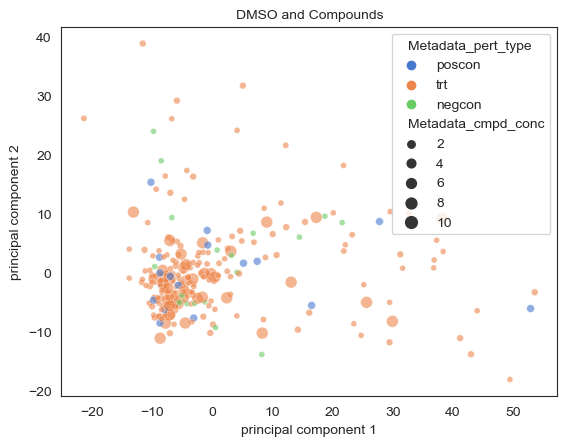

In [34]:
# One of many possible plots
fig = plt.figure()
ax = sns.scatterplot(
    x="principal component 1",
    y="principal component 2",
    hue="Metadata_pert_type",
    data=principalDf,
    size="Metadata_cmpd_conc",
    palette='muted',
    alpha=(0.6),
    marker="o",
    )
ax.set_title("DMSO and Compounds", fontsize=10)
ax.set_facecolor("w")